<a href="https://colab.research.google.com/github/navdeeps635/Shipment-Pricing-Prediction/blob/main/Shipment_Pricing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!chmod 600 /content/kaggle.json

In [3]:
!kaggle datasets download -d divyeshardeshana/supply-chain-shipment-pricing-data

  0% 0.00/581k [00:00<?, ?B/s]
100% 581k/581k [00:00<00:00, 131MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Archive:  supply-chain-shipment-pricing-data.zip
  inflating: SCMS_Delivery_History_Dataset.csv  


In [5]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.4 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC,SVR
from collections import Counter
from scipy import stats
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('/content/SCMS_Delivery_History_Dataset.csv')

In [8]:
pd.set_option('display.max_columns', None)
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [9]:
df.tail()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,Freight Included in Commodity Cost,134.03
10323,86823,103-ZW-T30,FPQ-15197,SO-50022,DN-4336,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Aug-15,4-Aug-15,11-Aug-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Zidovudine 30/60mg, dispersible tab...",Lamivudine/Zidovudine,Generic,30/60mg,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,Weight Captured Separately,Freight Included in Commodity Cost,85.82


In [10]:
df.shape

(10324, 33)

In [11]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

In [12]:
#drop unnecessary columns as they are not required for model training
columns_to_drop =  ['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #','Item Description','PQ First Sent to Client Date','PO Sent to Vendor Date']

df = df.drop(columns=columns_to_drop)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     10324 non-null  object 
 1   Managed By                  10324 non-null  object 
 2   Fulfill Via                 10324 non-null  object 
 3   Vendor INCO Term            10324 non-null  object 
 4   Shipment Mode               9964 non-null   object 
 5   Scheduled Delivery Date     10324 non-null  object 
 6   Delivered to Client Date    10324 non-null  object 
 7   Delivery Recorded Date      10324 non-null  object 
 8   Product Group               10324 non-null  object 
 9   Sub Classification          10324 non-null  object 
 10  Vendor                      10324 non-null  object 
 11  Molecule/Test Type          10324 non-null  object 
 12  Brand                       10324 non-null  object 
 13  Dosage                      858

In [14]:
#change datetype of date columns to datetime dtype
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'])
df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'])
df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'])

In [15]:
df_copy = df[['Scheduled Delivery Date','Delivered to Client Date','Delivery Recorded Date']]
df_copy['all_matching'] = df_copy.apply(lambda x: x['Scheduled Delivery Date'] == x['Delivered to Client Date'] == x['Delivery Recorded Date'], axis = 1)

In [16]:
df_copy.head()

,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,all_matching
0,2006-06-02,2006-06-02,2006-06-02,True
1,2006-11-14,2006-11-14,2006-11-14,True
2,2006-08-27,2006-08-27,2006-08-27,True
3,2006-09-01,2006-09-01,2006-09-01,True
4,2006-08-11,2006-08-11,2006-08-11,True


In [17]:
df_copy['diff'] = (df_copy['Delivery Recorded Date'] - df_copy['Delivered to Client Date']).dt.days

In [18]:
df_copy.head()

,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,all_matching,diff
0,2006-06-02,2006-06-02,2006-06-02,True,0
1,2006-11-14,2006-11-14,2006-11-14,True,0
2,2006-08-27,2006-08-27,2006-08-27,True,0
3,2006-09-01,2006-09-01,2006-09-01,True,0
4,2006-08-11,2006-08-11,2006-08-11,True,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country                     10324 non-null  object        
 1   Managed By                  10324 non-null  object        
 2   Fulfill Via                 10324 non-null  object        
 3   Vendor INCO Term            10324 non-null  object        
 4   Shipment Mode               9964 non-null   object        
 5   Scheduled Delivery Date     10324 non-null  datetime64[ns]
 6   Delivered to Client Date    10324 non-null  datetime64[ns]
 7   Delivery Recorded Date      10324 non-null  datetime64[ns]
 8   Product Group               10324 non-null  object        
 9   Sub Classification          10324 non-null  object        
 10  Vendor                      10324 non-null  object        
 11  Molecule/Test Type          10324 non-null  object    

In [20]:
def unique_value_counts(df):

    uniques_values = {}
    for col in df:
        if df[col].dtype == 'object':
            uniques_values[col] = df[col].value_counts()[:10]
    
    return uniques_values

In [21]:
unique_categories = unique_value_counts(df)

for col in ['Country','Managed By','Vendor']:
    print(col,'\n=======')
    print(unique_categories[col])
    print('\n')

Country 
South Africa     1406
Nigeria          1194
Côte d'Ivoire    1083
Uganda            779
Vietnam           688
Zambia            683
Haiti             655
Mozambique        631
Zimbabwe          538
Tanzania          519
Name: Country, dtype: int64


Managed By 
PMO - US                     10265
South Africa Field Office       57
Haiti Field Office               1
Ethiopia Field Office            1
Name: Managed By, dtype: int64


Vendor 
SCMS from RDC                                            5404
Orgenics, Ltd                                             754
S. BUYS WHOLESALER                                        715
Aurobindo Pharma Limited                                  668
Trinity Biotech, Plc                                      356
ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)           347
PHARMACY DIRECT                                           326
MYLAN LABORATORIES LTD (FORMERLY MATRIX LABORATORIES)     317
HETERO LABS LIMITED                                 

In [22]:
#check for missing values
print(df.isnull().sum()[df.isnull().sum().values>0].sort_values(ascending = False))
print('Total no. of missing values:',df.isnull().sum().sum())

Dosage                       1736
Shipment Mode                 360
Line Item Insurance (USD)     287
dtype: int64
Total no. of missing values: 2383


# Univariate Analysis

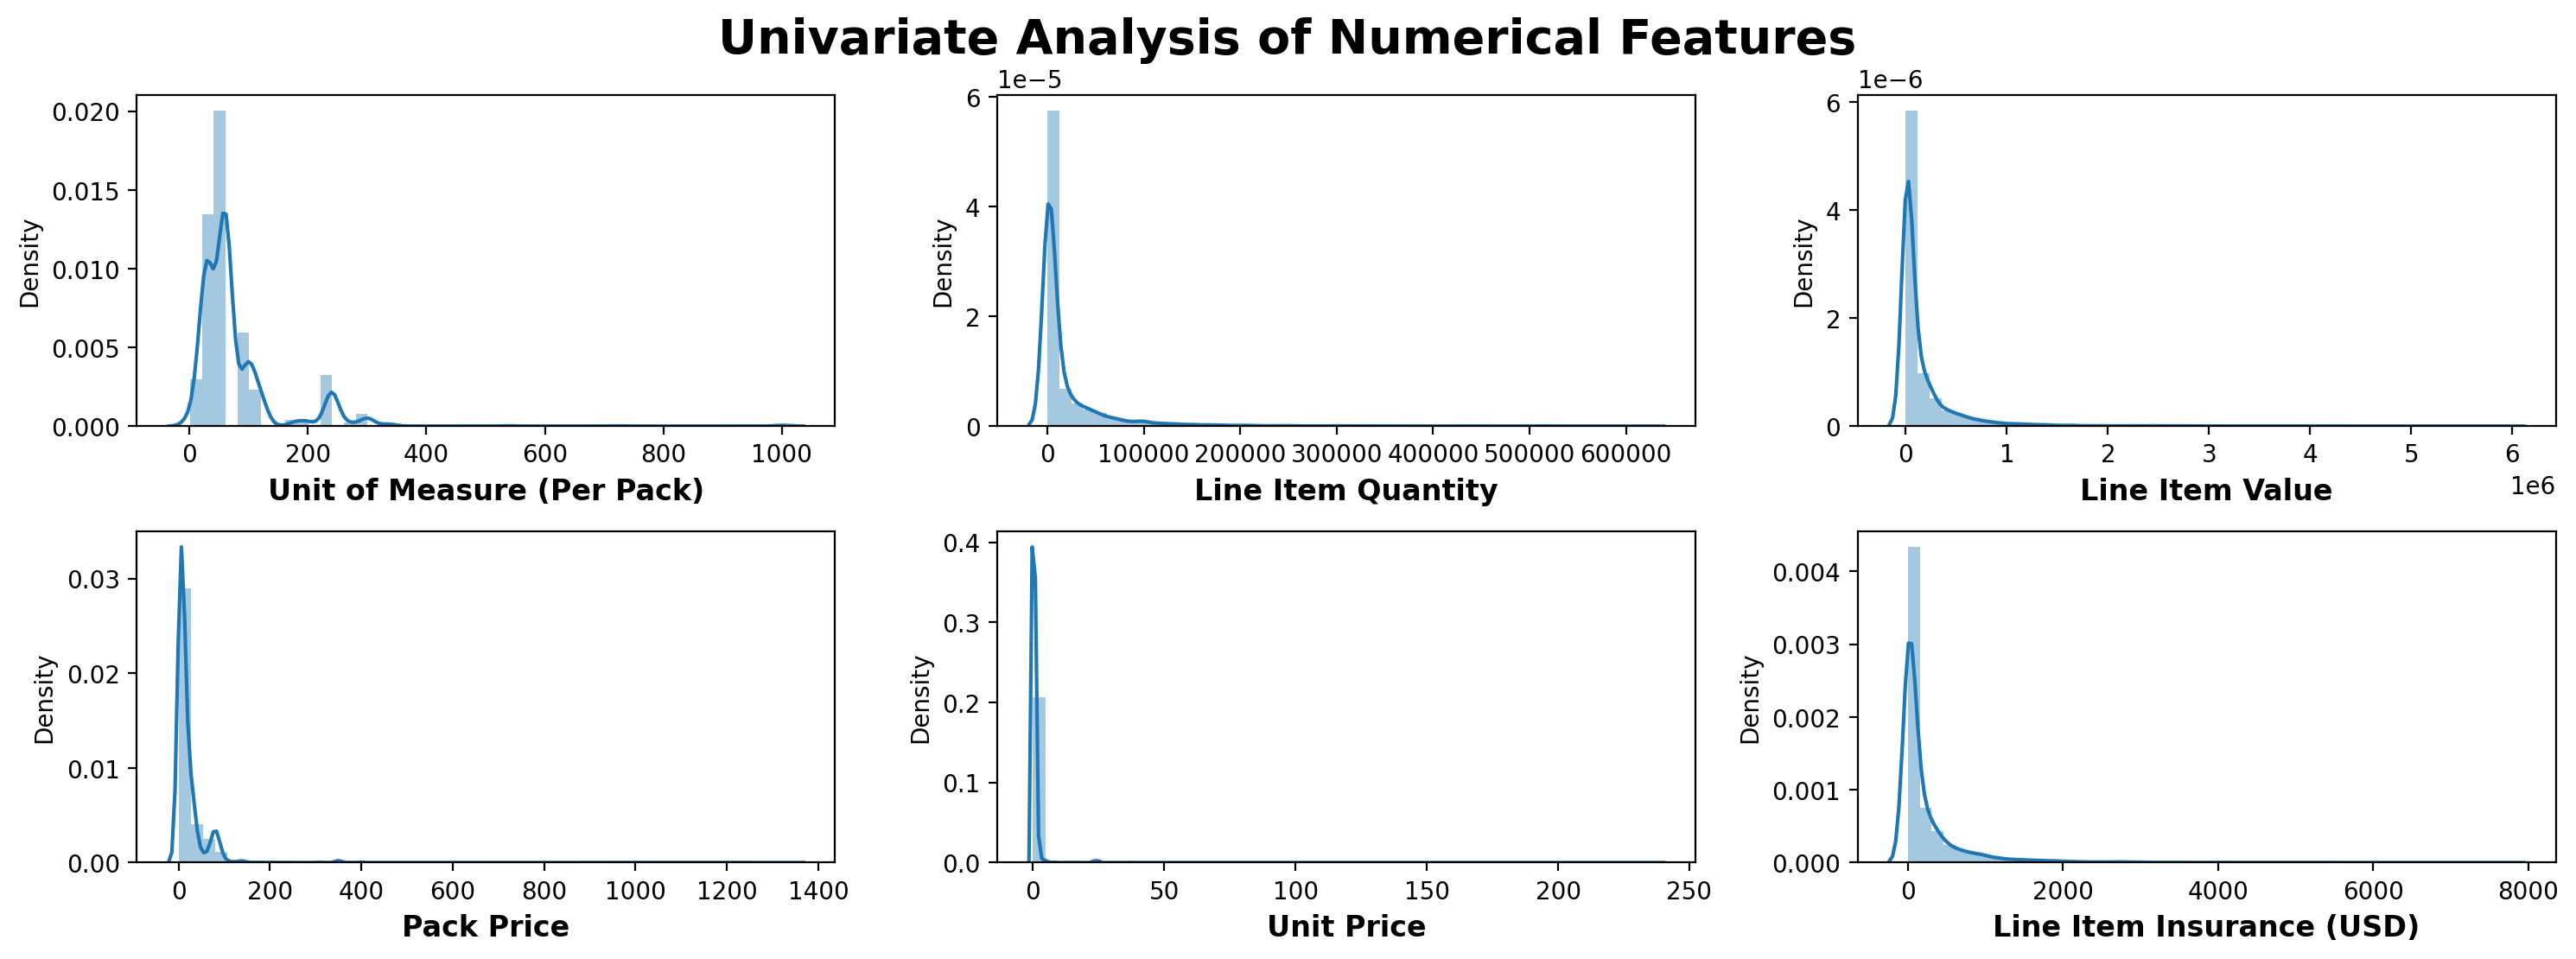

In [23]:
#check out the distribution of all numerical features

def univariate_plot_numerical(df):
    plt.figure(figsize=(15, 15),dpi=200)
    plt.suptitle('Univariate Analysis of Numerical Features',fontsize = 20, fontweight = 'bold',alpha = 1, y = 1.01)

    i = 0
    for col in df:
        if (df[col].dtype not in ['object','datetime64[ns]']):
            plt.subplot(6,3,i+1)
            sns.distplot(x = df[col])
            plt.xlabel(col, fontdict={'fontsize':12,'fontweight':'bold'})
            plt.tight_layout()
            i+=1
            
univariate_plot_numerical(df)

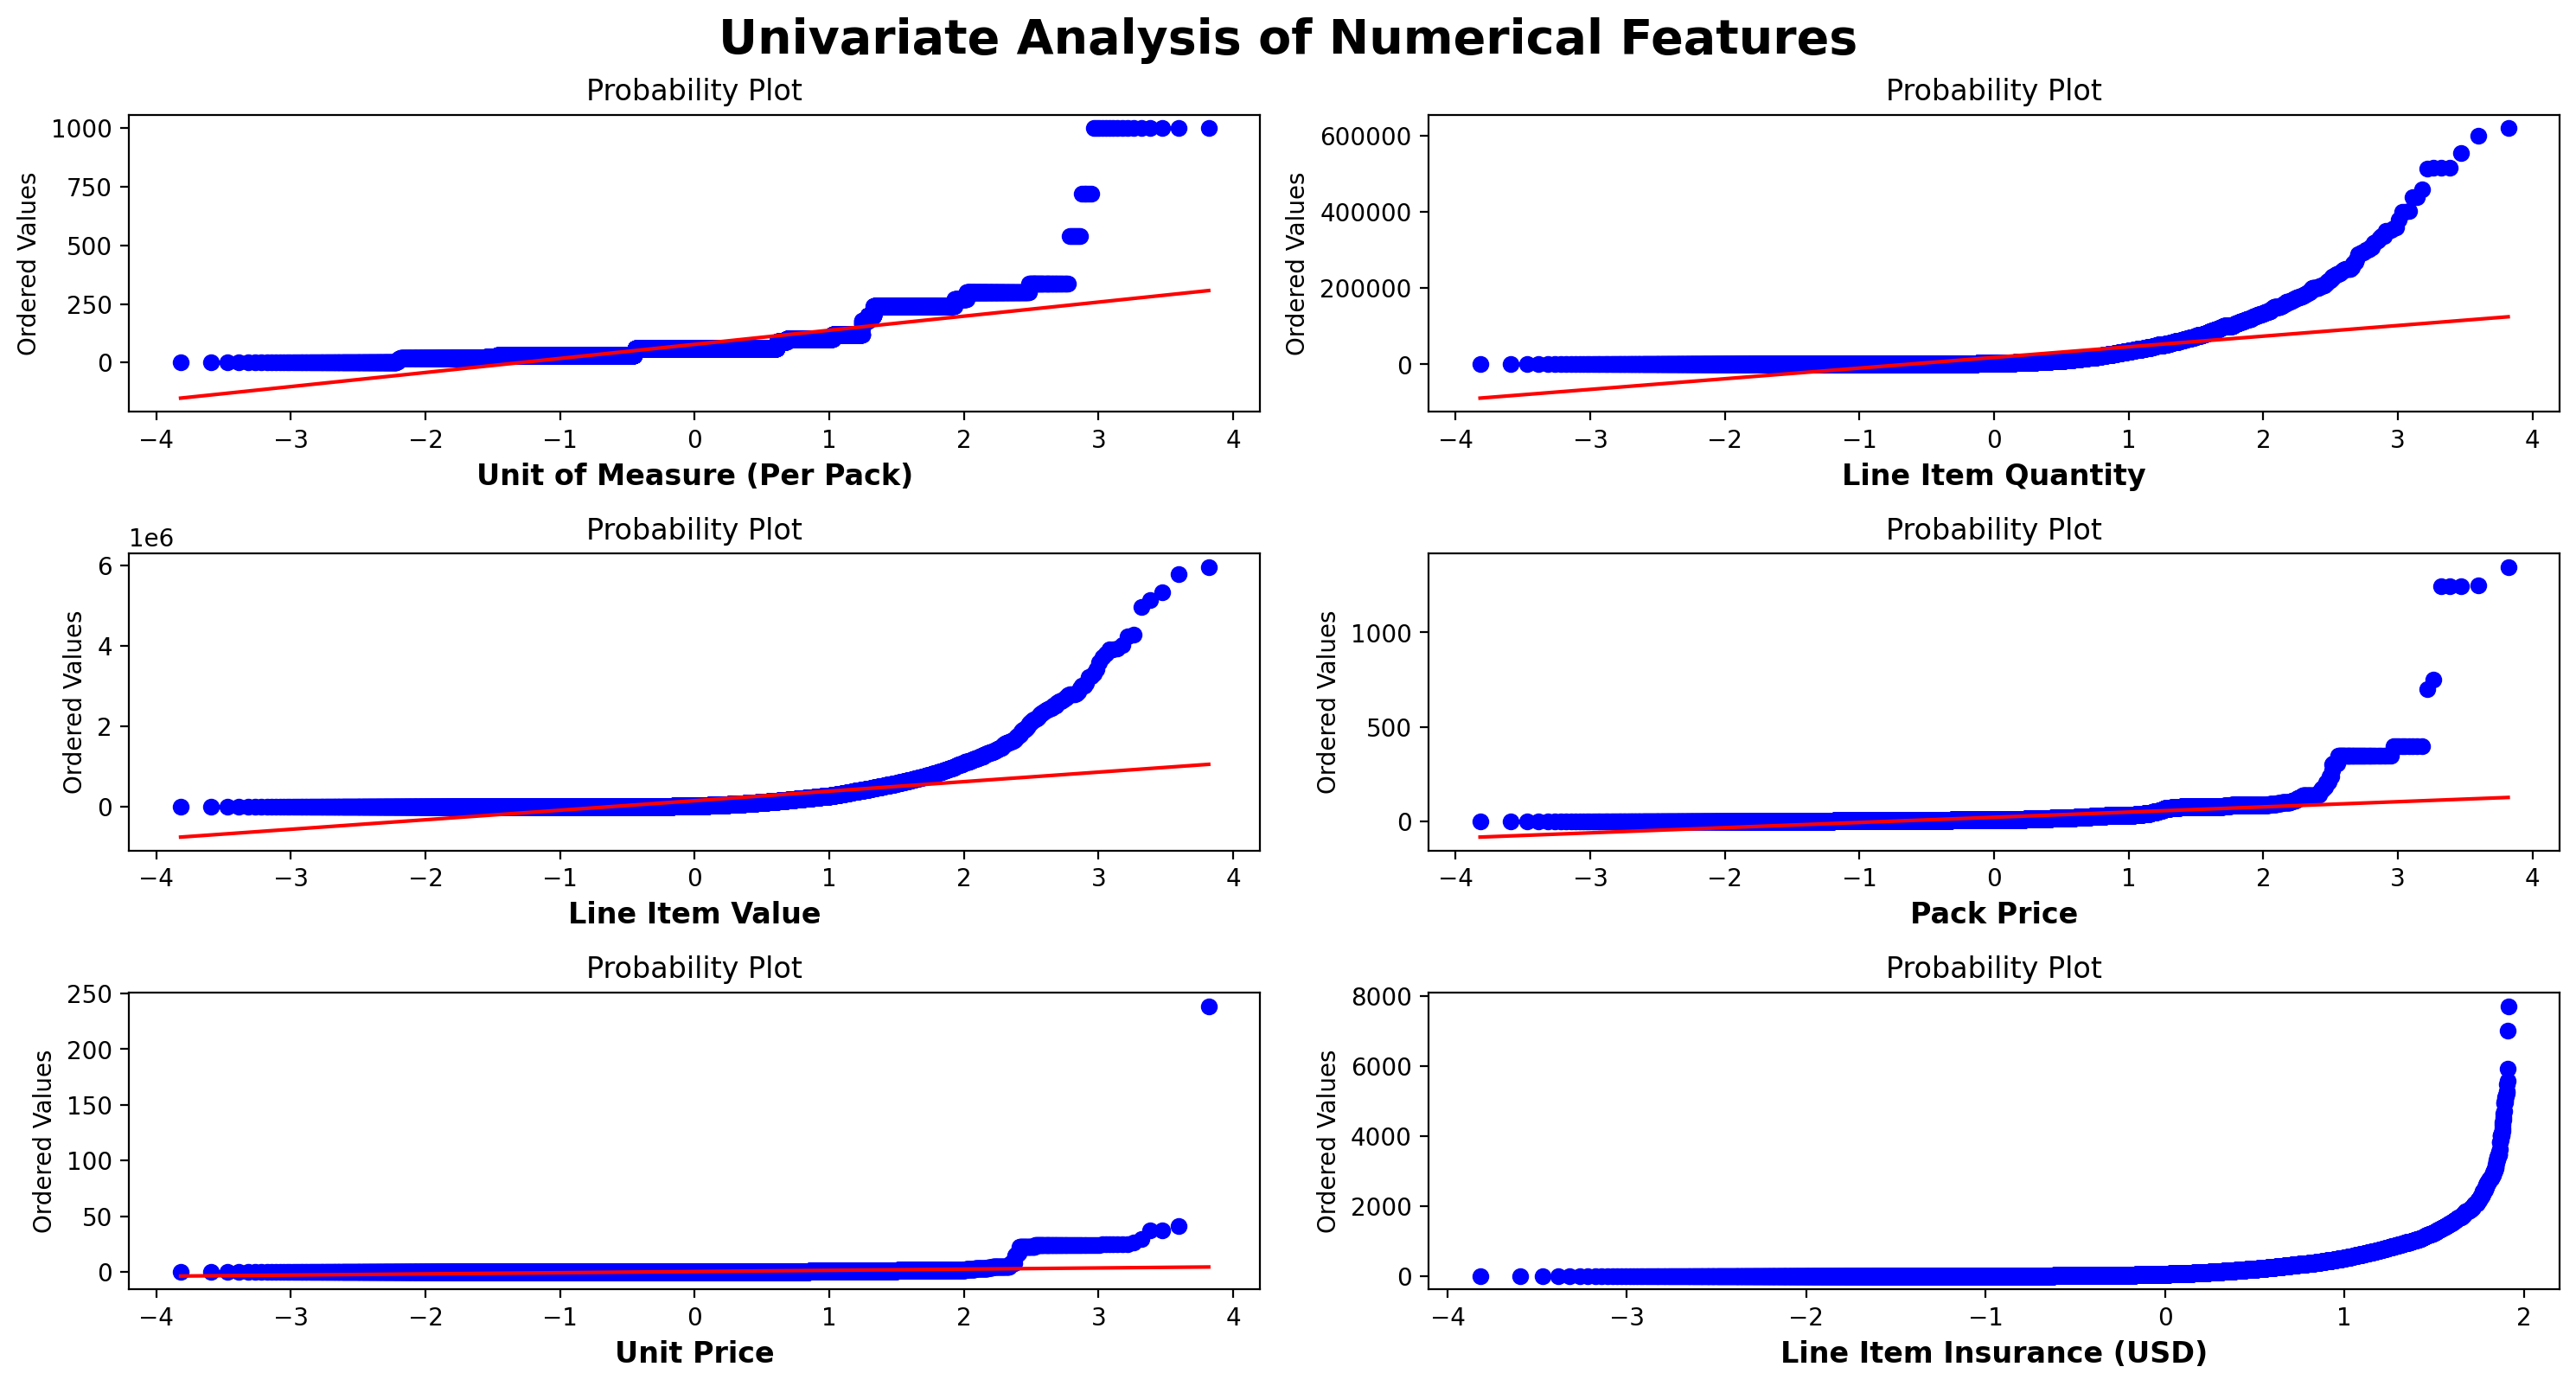

In [24]:
def univariate_plot_numerical(df):
    plt.figure(figsize=(15, 20),dpi=200)
    plt.suptitle('Univariate Analysis of Numerical Features',fontsize = 20, fontweight = 'bold',alpha = 1, y = 1.01)

    i = 0
    for col in df:
        if (df[col].dtype not in ['object','datetime64[ns]']):
            plt.subplot(8,2,i+1)
            stats.probplot(df[col],dist = 'norm', plot = plt)
            plt.xlabel(col, fontdict={'fontsize':12,'fontweight':'bold'})
            plt.tight_layout()
            i+=1
            
univariate_plot_numerical(df)

##Top 10 Countries with maximum number of orders

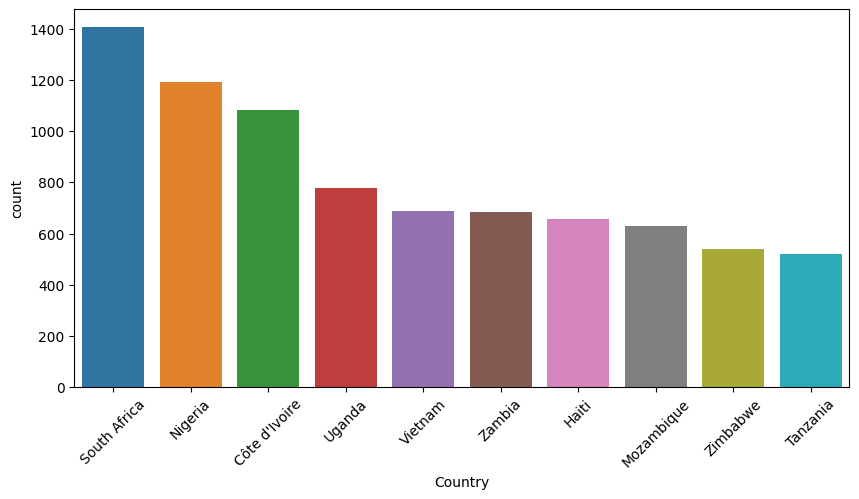

In [25]:
plt.figure(figsize=(10, 5),dpi=100)
sns.countplot(df['Country'],order = df['Country'].value_counts().nlargest(10).index)
plt.xlabel('Country')
plt.xticks(rotation = 45)
plt.show()

##Top 10 Countries having most Line Item Value

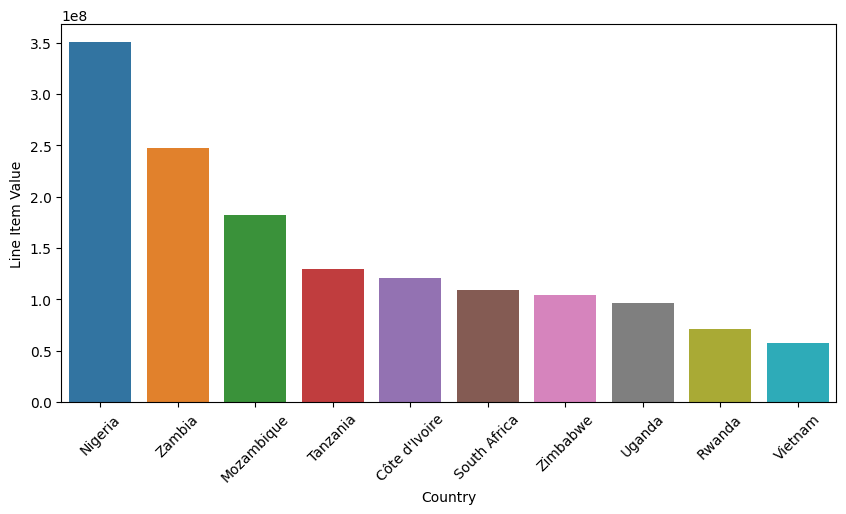

In [26]:
#country wise details
plt.figure(figsize=(10, 5),dpi=100)
grouped_data = df.groupby(['Country'])['Line Item Quantity','Line Item Value'].sum().sort_values(by = 'Line Item Value',ascending = False)[:10]
grouped_data= grouped_data.reset_index()
sns.barplot(x = 'Country',y = 'Line Item Value',data = grouped_data)
plt.xticks(rotation = 45)
plt.show()

##Top 10 Vendors with maximum Line Item Value

In [27]:
#group data on the basis of vendors
vendor_wise_grouped_data = df.groupby(['Vendor'])['Line Item Quantity','Line Item Value'].sum().sort_values(by = 'Line Item Value',ascending = False)

#select top15 vendors and reset_index
top_15_vendors = vendor_wise_grouped_data[:10].reset_index()
top_15_vendors

,Vendor,Line Item Quantity,Line Item Value
0,SCMS from RDC,134609946,1.085372e+09
1,"Orgenics, Ltd",1907097,1.477034e+08
2,Aurobindo Pharma Limited,16995950,9.138371e+07
3,MYLAN LABORATORIES LTD (FORMERLY MATRIX LABORA...,7739464,7.221367e+07
4,HETERO LABS LIMITED,7530849,4.288157e+07
5,CIPLA LIMITED,6247700,3.965869e+07
6,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),874072,2.944806e+07
7,STRIDES ARCOLAB LIMITED,7985106,2.248547e+07
8,"Trinity Biotech, Plc",637212,2.076934e+07
9,S. BUYS WHOLESALER,792615,9.891004e+06


# Data Preprocessing 

In [28]:
df.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [29]:
for col in ['Dosage Form','Dosage','Brand']:
    print(col,'\n=======')
    print(unique_categories[col])
    print('\n')

Dosage Form 
Tablet                               3532
Tablet - FDC                         2749
Test kit                             1575
Capsule                               729
Oral solution                         727
Chewable/dispersible tablet - FDC     239
Oral suspension                       214
Test kit - Ancillary                  161
Chewable/dispersible tablet           146
Delayed-release capsules              131
Name: Dosage Form, dtype: int64


Dosage 
300mg            990
200mg            932
600mg            772
150/300mg        600
150/300/200mg    580
10mg/ml          552
150mg            431
200/50mg         395
300/300mg        301
600/300/300mg    286
Name: Dosage, dtype: int64


Brand 
Generic      7285
Determine     799
Uni-Gold      373
Aluvia        250
Kaletra       165
Norvir        136
Stat-Pak      115
Bioline       113
Truvada        94
Videx          84
Name: Brand, dtype: int64




### Observations:

- Some values in Weight and Freight Cost column are referring to their respective ASN/DN No. the details of which are not accessible to us. Let' replace those values with np.nan and then impute the values using different approaches. 

- Similarly, Dosage Form mostly have three categories ('Tablet, Oral solution and Injection) but there there are number of categories with number of combinations. let's rename these categories with main categories    

- Similarly material that is being supplied from stock, doesn't require any Vendor INCO Term that will be encoded later on

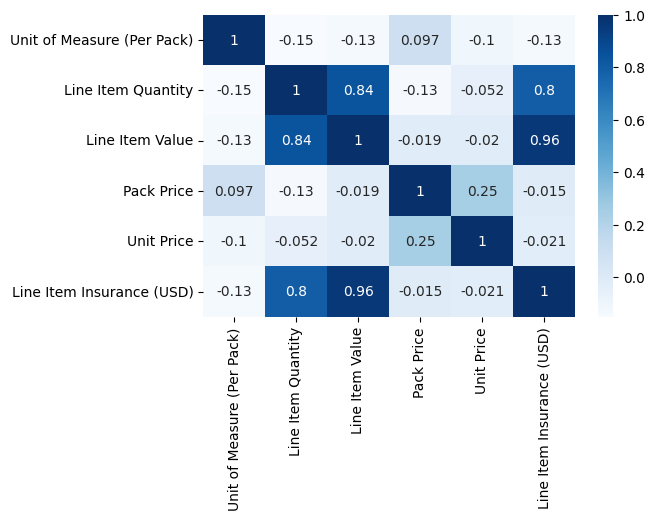

In [30]:
#correlation matrix of the dataset
plt.figure(figsize=(6, 4),dpi = 100)
sns.heatmap(df.corr(),annot=True,cmap='Blues')

In [31]:
df.describe([0.1,0.95,0.99])

,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
10%,30.000000,50.000000,6.081200e+02,2.240000,0.040000,0.840000
50%,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
95%,240.000000,90951.550000,7.028310e+05,80.000000,1.600000,1082.032000
99%,300.000000,186888.780000,1.592935e+06,139.000000,5.000000,2455.284000
max,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


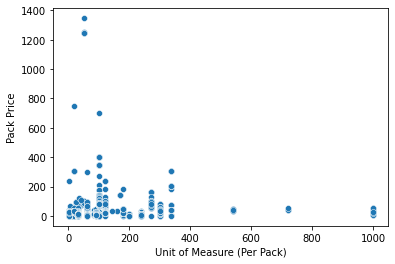

In [32]:
sns.scatterplot(x = 'Unit of Measure (Per Pack)',y = 'Pack Price',data = df)

In [33]:
len(df[(df['Pack Price']>600) & (df['Unit of Measure (Per Pack)']>400)])

0

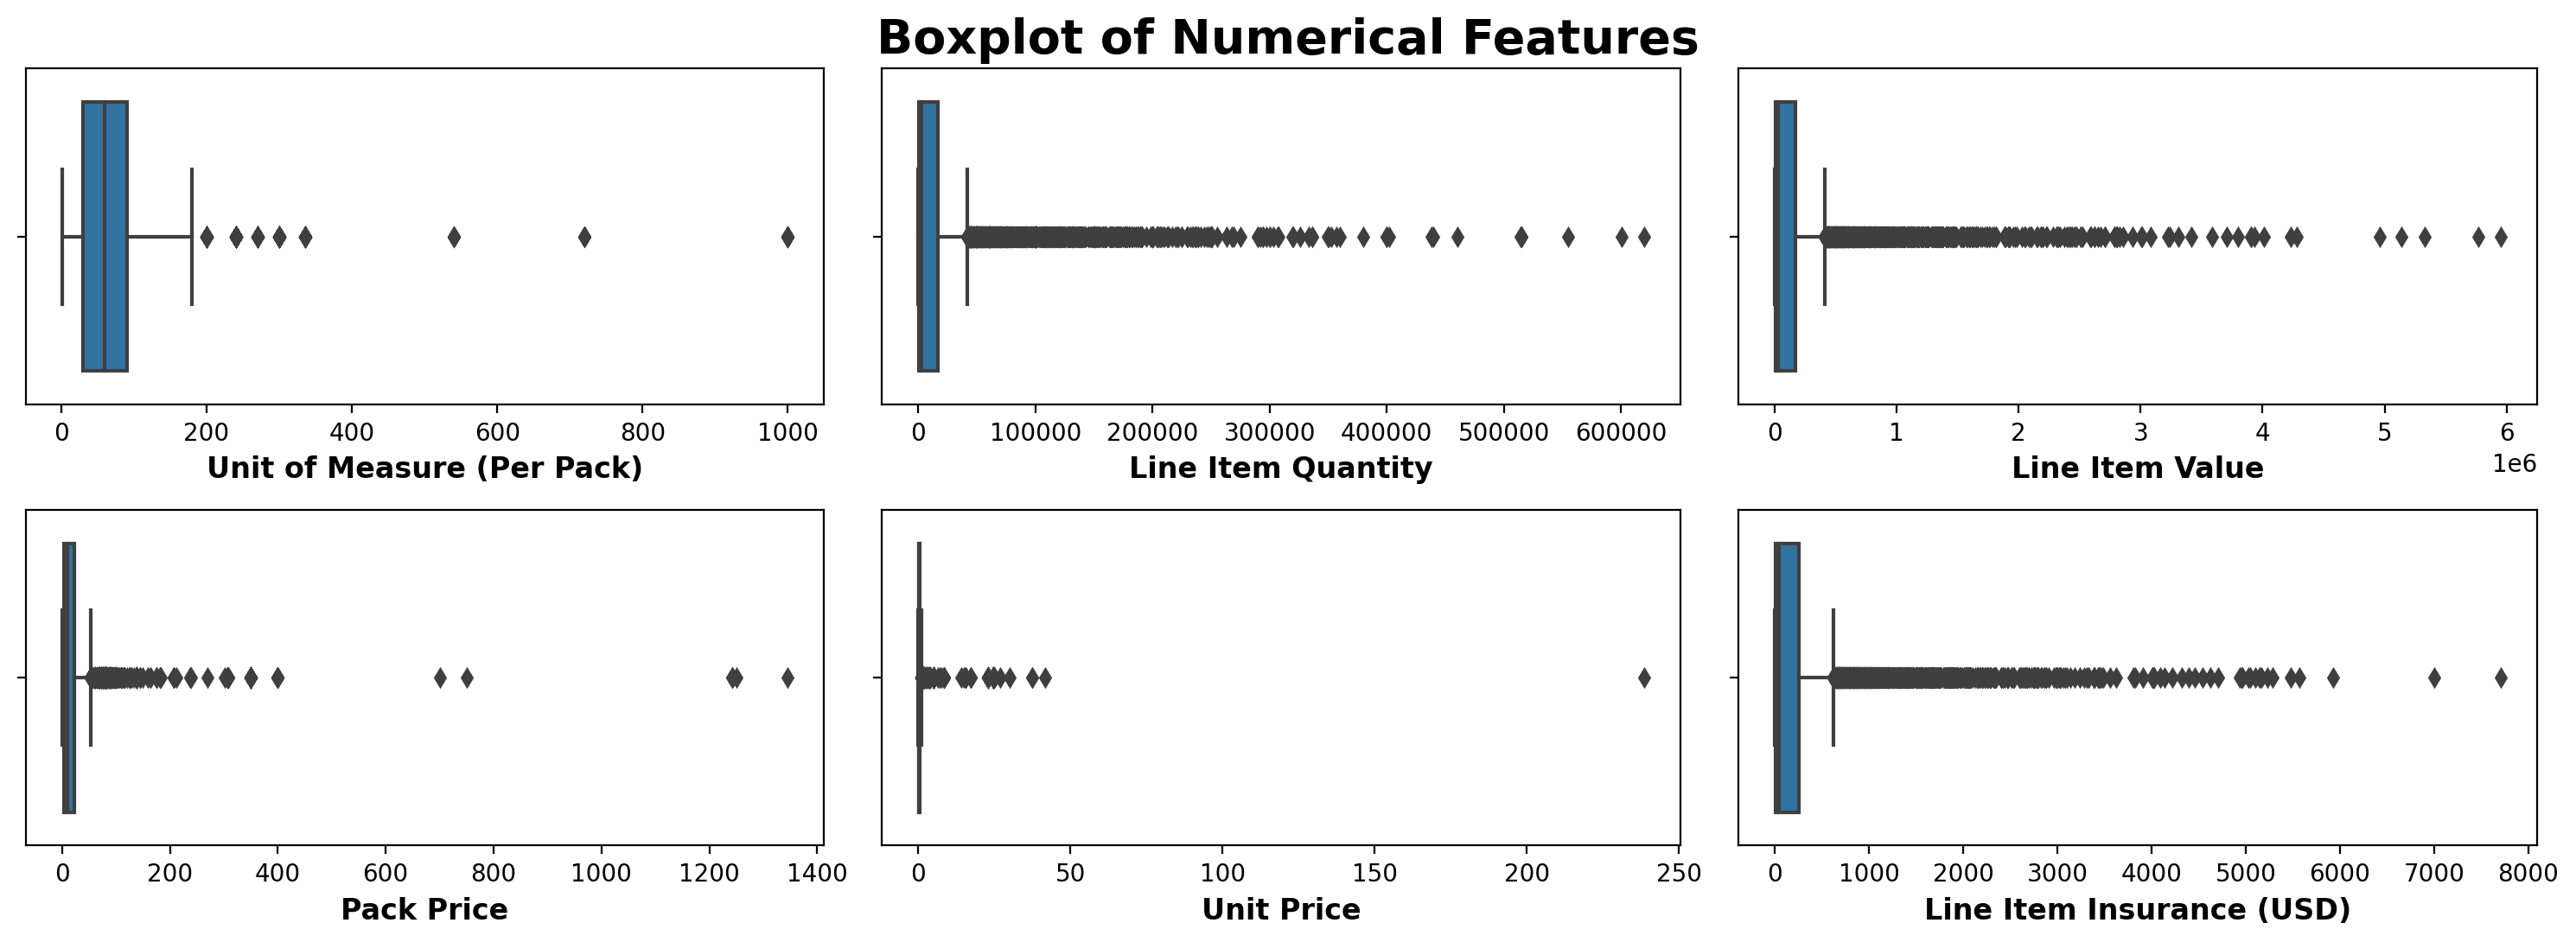

In [34]:
#check out the boxplot of all numerical features

def boxplot(df):
    plt.figure(figsize=(15, 15),dpi=200)
    plt.suptitle('Boxplot of Numerical Features',fontsize = 20, fontweight = 'bold',alpha = 1, y = 1.01)

    i = 0
    for col in df:
        if (df[col].dtype not in ['object','datetime64[ns]']):
            plt.subplot(6,3,i+1)
            sns.boxplot(x = df[col])
            plt.xlabel(col, fontdict={'fontsize':12,'fontweight':'bold'})
            plt.tight_layout()
            i+=1
            
boxplot(df)

#### Observation:
- Outliers are observed in almost all the numerical features which may be helpful to us while model training. However we will check the ouliers again after imputation. so, let's not remove these outleirs.

In this section we will perform the following tasks:

#### 1. Handling missing values:
There are number of ways to deal with missing values

   <img src="https://miro.medium.com/max/828/1*vhwpR-qisCWFdpmAugxcIA.webp" width="500"/>



**In deletion,** the particular feature or row having huge number of missing values are removed.

**In imputation,** the missing values are imputed using some techniques such as:
#### A. Univariate imputation techniques:
- the missing values are replaced using the balance data of that particular feature. Most famous and simple methods are **Mean,Median and Mode**. Out of which mean and median are used for numerical feature imputation whereas mode is used for categorical feature imputation. 

#### B. Multivariate imputation techniques:
- In this feature are imputed based on their relation with other features. Most used imputation techniques are:
    - **KNN Imputer:** KNN algorithm is used for feature imputation. it is suitable for both categorical as well as numerical features.
    - **Iterative Imputation:** MICE(Multiple Imputation by Chained Equation) technique is used under this imputation. in this any machine learning algorithm can be used for multiple iteration and imputing the features. it is suitable for both categorical as well as numerical features.
 
#### 2. Handling outliers:
- Oulier may impact the performance of the models but sometime they might be helpul. most commonly used techniques for treating outliers are:
    - **Z-score:**  we use the concept of standard normal distribution. every value outside -3 to +3 is treated as outlier and can be treated depending upon the problem we are trying to solve 
    
   <img src="https://miro.medium.com/max/828/1*ARpoeY3MdhFImq0JXAXtRw.webp" width="500"/>

    - **IQR method:** we use the concept of inter quartile range. every value outside range of lower limit to upper limit is treated as outlier and can be treated depending upon the problem statement
    
   <img src="https://www.statology.org/wp-content/uploads/2021/01/iqrOutlier1-768x204.png" width="500"/>
   
  - **Percentile method:** Based on problem statement and domain knowledge, we can choose the upper and lower limit for outlier treatment using percentile method

#### 3. Categorical features encoding
- Model do understand numerical values only, hence categorical features needs to be converted into numerical values. most common methods are given below:
    - One Hot Encoding
    - Label Encoding
    - Ordinal Encoding
    - Count of Frequency Encoding
    - Target Guided Ordinal Encoding
    - Probability Ratio Encoding

#### 4. Feature scaling
- Every feature is scaled to same range for having better results.

In [35]:
new_df = df.copy()

In [36]:
new_df.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [37]:
new_df.loc[(new_df['Freight Cost (USD)'].str.contains('See')) | (new_df['Freight Cost (USD)'].str.contains('Invoiced')),'Freight Cost (USD)'] = np.nan
new_df.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [38]:
new_df.loc[new_df['Freight Cost (USD)'].str.contains('Commodity', na=False),'Freight Cost (USD)'] = 0
new_df.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [39]:
new_df.loc[(new_df['Weight (Kilograms)'].str.contains('See')) | (new_df['Weight (Kilograms)'].str.contains('Captured')),'Weight (Kilograms)'] = np.nan
new_df.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [40]:
#check for missing values
print(new_df.isnull().sum()[new_df.isnull().sum().values>0].sort_values(ascending = False))
print('Total no. of missing values:',new_df.isnull().sum().sum())

Weight (Kilograms)           3952
Freight Cost (USD)           2684
Dosage                       1736
Shipment Mode                 360
Line Item Insurance (USD)     287
dtype: int64
Total no. of missing values: 9019


In [41]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country                     10324 non-null  object        
 1   Managed By                  10324 non-null  object        
 2   Fulfill Via                 10324 non-null  object        
 3   Vendor INCO Term            10324 non-null  object        
 4   Shipment Mode               9964 non-null   object        
 5   Scheduled Delivery Date     10324 non-null  datetime64[ns]
 6   Delivered to Client Date    10324 non-null  datetime64[ns]
 7   Delivery Recorded Date      10324 non-null  datetime64[ns]
 8   Product Group               10324 non-null  object        
 9   Sub Classification          10324 non-null  object        
 10  Vendor                      10324 non-null  object        
 11  Molecule/Test Type          10324 non-null  object    

In [42]:
new_df['Weight (Kilograms)'] = new_df['Weight (Kilograms)'].astype(float)
new_df['Freight Cost (USD)'] = new_df['Freight Cost (USD)'].astype(float)

In [43]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country                     10324 non-null  object        
 1   Managed By                  10324 non-null  object        
 2   Fulfill Via                 10324 non-null  object        
 3   Vendor INCO Term            10324 non-null  object        
 4   Shipment Mode               9964 non-null   object        
 5   Scheduled Delivery Date     10324 non-null  datetime64[ns]
 6   Delivered to Client Date    10324 non-null  datetime64[ns]
 7   Delivery Recorded Date      10324 non-null  datetime64[ns]
 8   Product Group               10324 non-null  object        
 9   Sub Classification          10324 non-null  object        
 10  Vendor                      10324 non-null  object        
 11  Molecule/Test Type          10324 non-null  object    

In [44]:
#create a class to make custom tranformer for numerical features imputation

class NumericalImputationMICE(BaseEstimator, TransformerMixin): 
    
    def __init__(self,columns):
        self.columns = columns
        return None
    
    def fit(self, X, y = None):
        #the type of X might be a DataFrame or a NumPy array depending on the previous transformer object that you use in the pipeline
        return self
    
    def transform(self, X, y = None):
        """
        Impute numeric data using MICE imputation with Decision Tree Regressor.
        (we can use any other regressors to impute the data)
        """
        impute_numeric = IterativeImputer(estimator = DecisionTreeRegressor(),max_iter = 3,initial_strategy = "mean")
        imputed_data = impute_numeric.fit_transform(X[self.columns])
        X[self.columns] =  imputed_data.astype(int)

        return X

In [45]:
#create a class to make custom tranformer for categorical features imputation

class CategoricalImputationMICE(BaseEstimator, TransformerMixin): 
    
    def __init__(self,columns):
        self.columns = columns
        return None
    
    def fit(self, X, y = None):
        #the type of X might be a DataFrame or a NumPy array depending on the previous transformer object that you use in the pipeline

        return self
    
    def transform(self, X, y = None):
        """
        Impute categoric data using MICE imputation with Decision Tree Classifier.
        Steps:
        1. Ordinal Encode the non-null values
        2. Use MICE imputation with Decision Tree Classifier to impute the ordinal encoded data
        (we can use any other classifier to impute the data)
        3. Inverse transform the ordinal encoded data.
        """

        fit_encoder={}
        for col in self.columns:
            #Label encode train data
            nn_vals = X[col][X[col].notnull()]
            fit_encoder[col] = LabelEncoder().fit(nn_vals)
            nn_vals_arr = np.array(fit_encoder[col].transform(nn_vals)).reshape(-1,)
            X[col].loc[X[col].notnull()] = nn_vals_arr

        #Impute the data using MICE with Gradient Boosting Classifier
        impute_categoric = IterativeImputer(estimator = DecisionTreeClassifier(), max_iter = 3, initial_strategy='most_frequent')
        imputed_data = impute_categoric.fit_transform(X[self.columns])

        X[self.columns] =  imputed_data.astype(int)

        #Inverse Transform categorical features
        for col in self.columns:
            #train_arr= np.array(df[col]).reshape(-1,1)
            X[col] = fit_encoder[col].inverse_transform(X[col])

        return X

In [46]:
num_cols = new_df.select_dtypes(include = ['int','float']).columns
num_cols

Index(['Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value',
       'Pack Price', 'Unit Price', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

In [47]:
cat_cols = new_df.select_dtypes(include = ['object']).columns
cat_cols

Index(['Country', 'Managed By', 'Fulfill Via', 'Vendor INCO Term',
       'Shipment Mode', 'Product Group', 'Sub Classification', 'Vendor',
       'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form',
       'Manufacturing Site', 'First Line Designation'],
      dtype='object')

In [48]:
impute_numerical_features = NumericalImputationMICE(columns=num_cols)

new_df = impute_numerical_features.fit_transform(new_df)

In [49]:
new_df.isnull().sum()

Country                          0
Managed By                       0
Fulfill Via                      0
Vendor INCO Term                 0
Shipment Mode                  360
Scheduled Delivery Date          0
Delivered to Client Date         0
Delivery Recorded Date           0
Product Group                    0
Sub Classification               0
Vendor                           0
Molecule/Test Type               0
Brand                            0
Dosage                        1736
Dosage Form                      0
Unit of Measure (Per Pack)       0
Line Item Quantity               0
Line Item Value                  0
Pack Price                       0
Unit Price                       0
Manufacturing Site               0
First Line Designation           0
Weight (Kilograms)               0
Freight Cost (USD)               0
Line Item Insurance (USD)        0
dtype: int64

In [50]:
#refer link https://www.linkedin.com/pulse/what-different-between-shipping-shipment-rudy-sangian/?trk=portfolio_article-card_title
#Shipment Price = Line Item Value + Freight Cost + Line Item Insurance

new_df['Shipment Price (USD)'] = new_df['Line Item Value'] + new_df['Freight Cost (USD)'] + new_df['Line Item Insurance (USD)']

In [51]:
#trf_df.loc[trf_df['Country'] == 'Côte d\'Ivoire','Country'] = 'Cote d Ivoire'

In [52]:
new_df.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Shipment Price (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551,29,0,Ranbaxy Fine Chemicals LTD,Yes,13,780,0,1331
1,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200,6,0,"Aurobindo Unit III, India",Yes,358,4521,9,10730
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000,80,0,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653,65,41718
3,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360,3,0,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007,275,143642
4,Vietnam,PMO - US,Direct Drop,EXW,Air,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600,3,0,"Aurobindo Unit III, India",Yes,7590,45450,202,167252


From univariate Anaysis we have seen that some of the features (like **Bike count per Hour,** **Wind Speed,** **Solar Radiation** and **visibilty** are not normally distributed. It may impact the impact the performance of the model and it needs to tranformed using some kind of transoformers mentioned below:

Genrally for all those features, we shall check the distribution using all these transformations and shall pick up the best suitable one.

**Function Transformations:**
1. **Log transformation:** It tranform the feeature by taking log of the feature. This transformation is mostly used, we the distribution is highy right skewed.
2. **Square tranformation:** It tranform the feeature by taking by taking square of the feature . It is mostly suitble for left skewed distribution
3. **Square root tranformation:** It tranform the feeature by taking by taking square-root of the feature . It is mostly suitble for right skewed distribution
4. **Reciprocal transformation:** The reciprocal transformation will give little effect on the shape of the distribution. This transformation can be only used for non-zero values.

**Power Transformations:**
1. **Box-Cox transformation:** It tranform the feeature by choosing appropriate value of power of the feature.It can't be applied to zero or negative values.
2. **Yeo-Johnson transformation:** It tranform the feeature by choosing appropriate value of power of the feature.It can be applied to positive, zero or negative values.

The major cons of using log transformation and reciprocal transformation if any value is '0' then log0 = infinity and in inverse it becomes 1/0 =infinity, so if the dataset has 0 in it and we cannot replace zero with other means then we better avoid usage of log and inverse transformation as medium to cure skewness.

As a result of which, **log(x)** is replaced with **log1p(x)** which is equal to log(1+x) and this way zero values can also be handled in log tranformation.

Generally the skewness is ranged between -1 and 1. if

- the skewness is between 0.5 to -0.5 then it is symmetrical
- the skewness is between 0.5 to 1 or -0.5 to -1 they are lightly skewed
- the skewness is higher than 1 or -1 then it is highly skewed


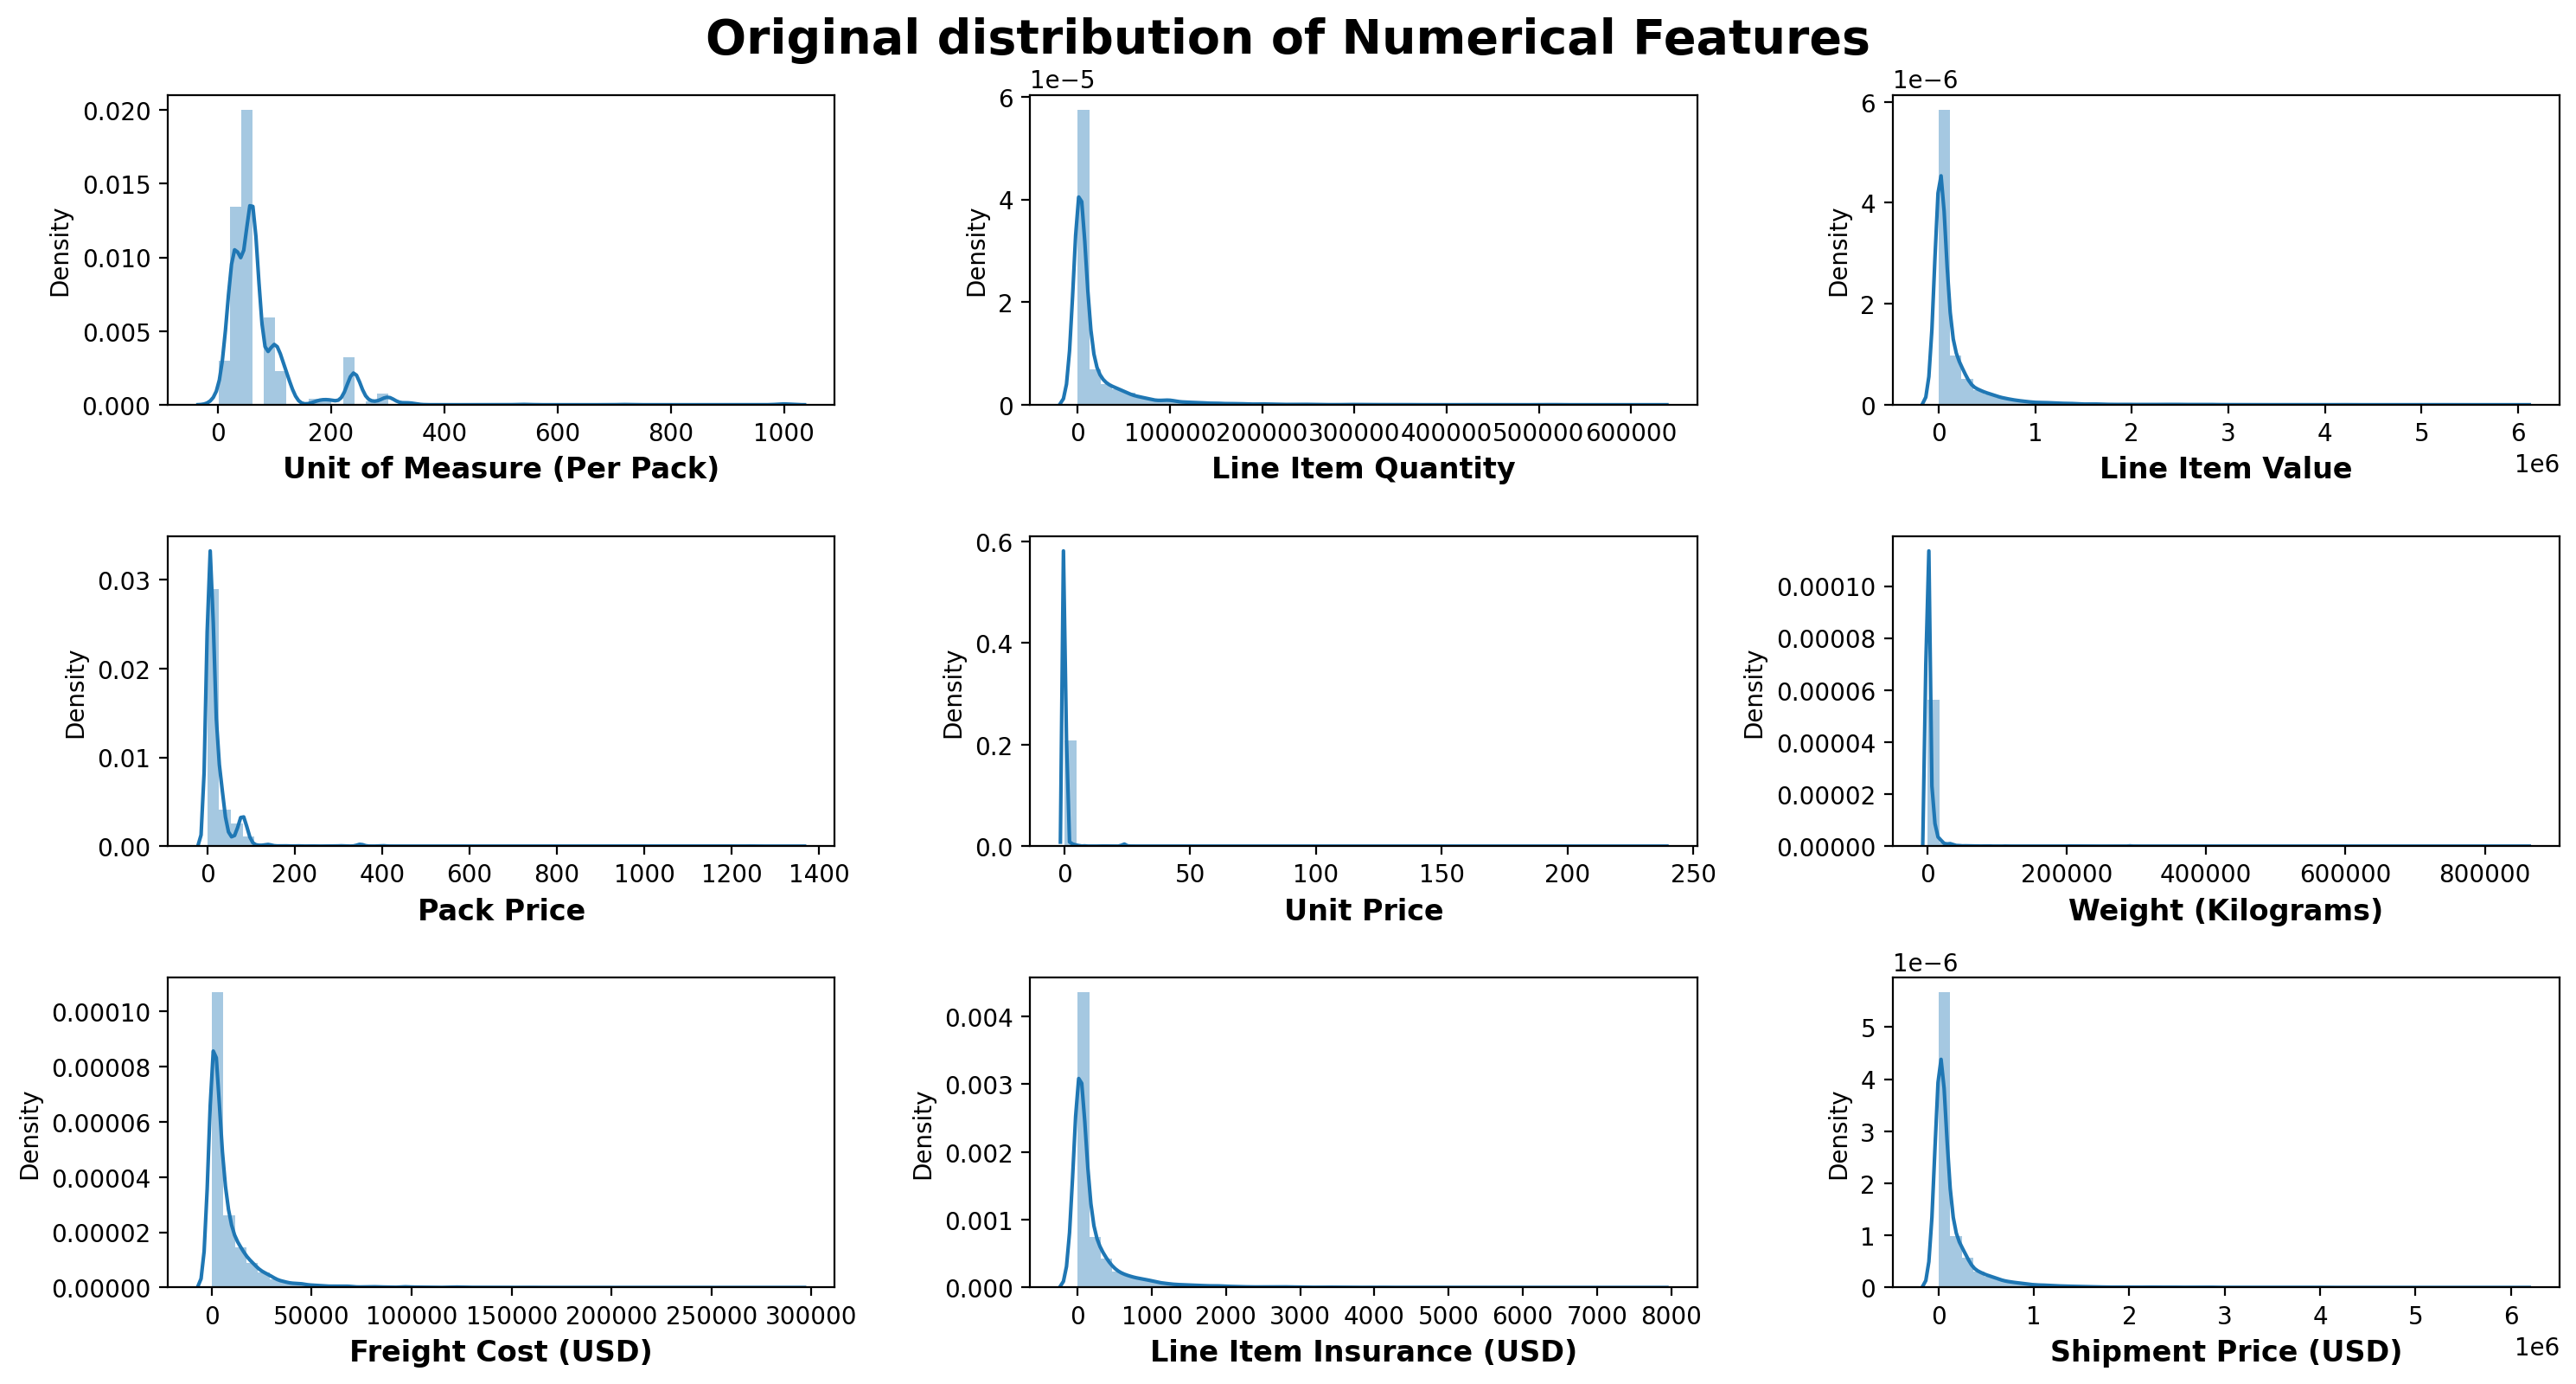

In [53]:
#check out the distribution of all numerical features

def univariate_plot_numerical(df):
    plt.figure(figsize=(15, 15),dpi=200)
    plt.suptitle('Original distribution of Numerical Features',fontsize = 20, fontweight = 'bold',alpha = 1, y = 1.01)

    i = 0
    for col in df:
        if (df[col].dtype not in ['object','datetime64[ns]']):
            plt.subplot(6,3,i+1)
            sns.distplot(x = df[col])
            plt.xlabel(col, fontdict={'fontsize':12,'fontweight':'bold'})
            plt.tight_layout()
            i+=1
            
univariate_plot_numerical(new_df)

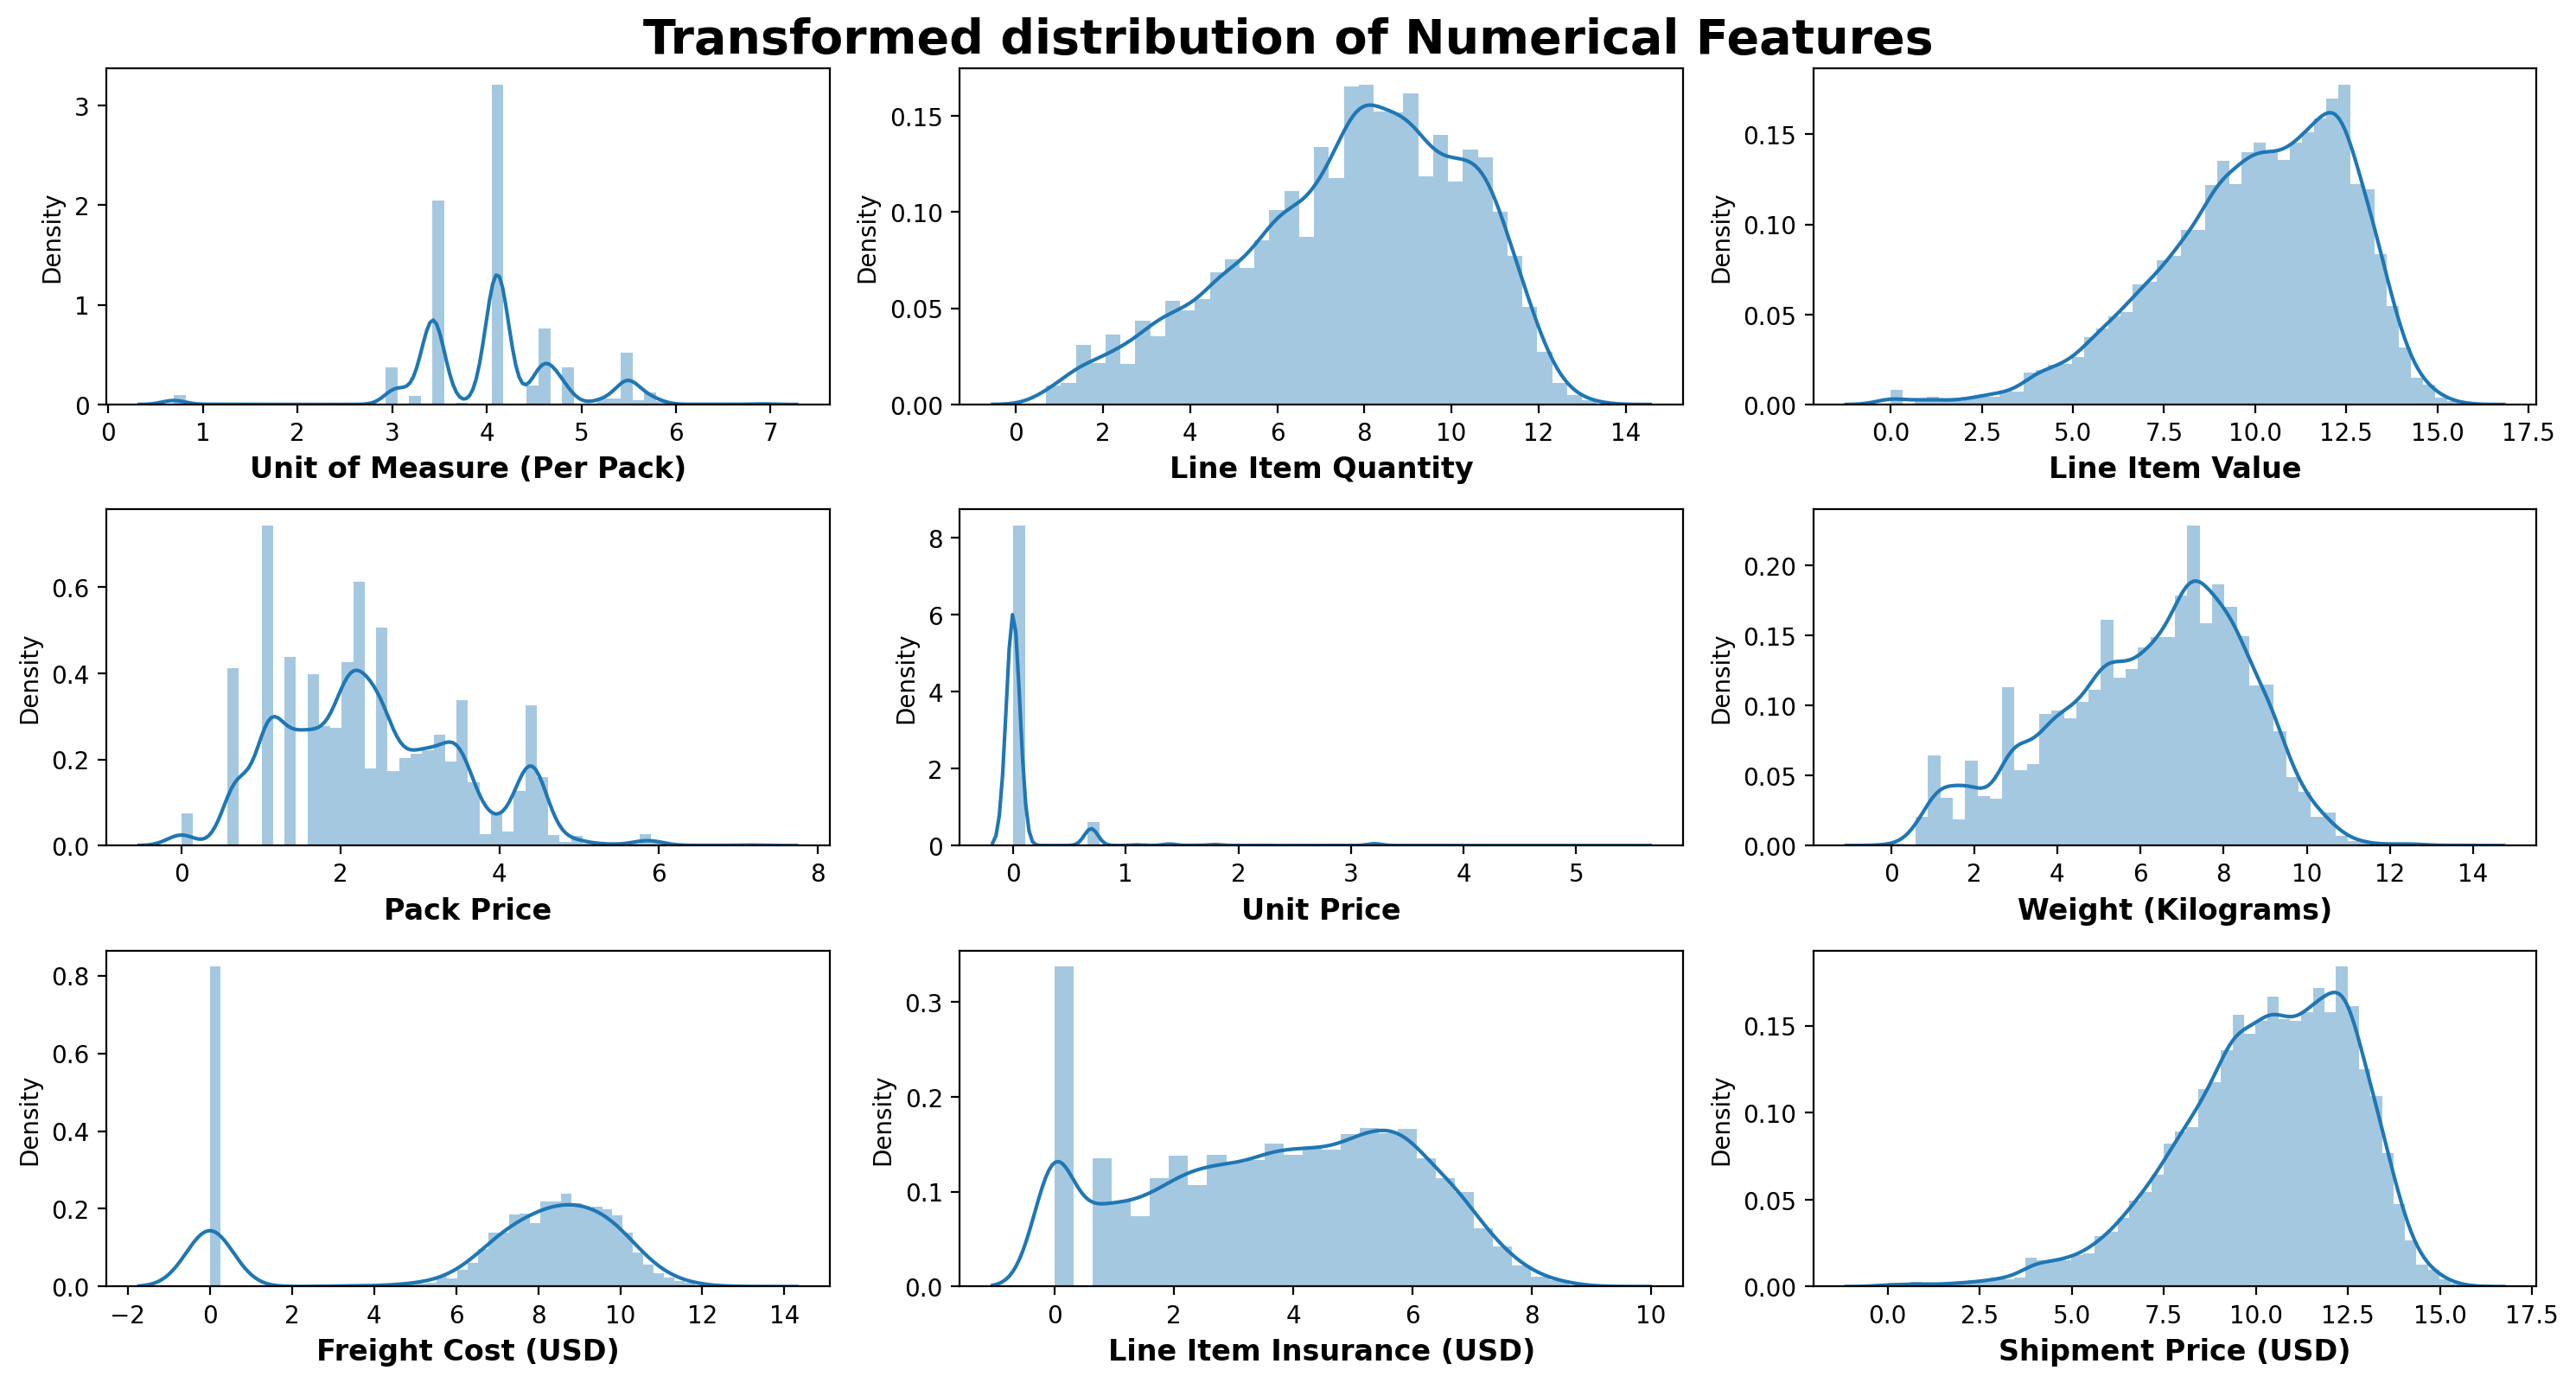

In [54]:
#check out the distribution of all numerical features

def univariate_plot_numerical(df):
    plt.figure(figsize=(15, 15),dpi=200)
    plt.suptitle('Transformed distribution of Numerical Features',fontsize = 20, fontweight = 'bold',alpha = 1, y = 1.01)

    i = 0
    for col in df:
        if (df[col].dtype not in ['object','datetime64[ns]']):
            plt.subplot(6,3,i+1)
            sns.distplot(x = np.log1p(df[col]))
            plt.xlabel(col, fontdict={'fontsize':12,'fontweight':'bold'})
            plt.tight_layout()
            i+=1
            
univariate_plot_numerical(new_df)

In [55]:
impute_categorical_features = CategoricalImputationMICE(columns=cat_cols)

new_df_copy = impute_categorical_features.fit_transform(new_df)

In [56]:
#split dataset into dependent and independent features
X = new_df.drop(['Shipment Price (USD)','Scheduled Delivery Date','Delivered to Client Date','Delivery Recorded Date'],axis=1)
y = new_df['Shipment Price (USD)']

In [57]:
#split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Shape of X_train:',X_train.shape)
print('Shape of X_test:',X_test.shape)

#training ctegorical columns
train_cat_cols = X_train.select_dtypes(include = 'object').columns
print('Categorical Columns in training dataset:',train_cat_cols)
print('='*85)

#training numerical columns
train_num_cols = X_train.select_dtypes(include = ['int64','float64']).columns
print('Numerical Columns in training dataset:',train_num_cols)

Shape of X_train: (7743, 22)
Shape of X_test: (2581, 22)
Categorical Columns in training dataset: Index(['Country', 'Managed By', 'Fulfill Via', 'Vendor INCO Term',
       'Shipment Mode', 'Product Group', 'Sub Classification', 'Vendor',
       'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form',
       'Manufacturing Site', 'First Line Designation'],
      dtype='object')
Numerical Columns in training dataset: Index(['Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value',
       'Pack Price', 'Unit Price', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')


In [58]:
X.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,150/200/30mg,Test kit,30,19,551,29,0,Ranbaxy Fine Chemicals LTD,Yes,13,780,0
1,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200,6,0,"Aurobindo Unit III, India",Yes,358,4521,9
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,200/300mg,Test kit,100,500,40000,80,0,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653,65
3,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360,3,0,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007,275
4,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600,3,0,"Aurobindo Unit III, India",Yes,7590,45450,202


In [59]:
numerical_imputer = NumericalImputationMICE(columns=num_cols)

new_X_copy = numerical_imputer.fit_transform(X)

In [60]:
new_X_copy.head()

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,150/200/30mg,Test kit,30,19,551,29,0,Ranbaxy Fine Chemicals LTD,Yes,13,780,0
1,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200,6,0,"Aurobindo Unit III, India",Yes,358,4521,9
2,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,200/300mg,Test kit,100,500,40000,80,0,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653,65
3,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,150mg,Tablet,60,31920,127360,3,0,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007,275
4,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,Stavudine,Generic,30mg,Capsule,60,38000,121600,3,0,"Aurobindo Unit III, India",Yes,7590,45450,202


In [61]:
categorical_imputer = CategoricalImputationMICE(columns=cat_cols)

new_X_train = categorical_imputer.fit_transform(new_X_copy)

In [62]:
new_X_train.isnull().sum()

Country                       0
Managed By                    0
Fulfill Via                   0
Vendor INCO Term              0
Shipment Mode                 0
Product Group                 0
Sub Classification            0
Vendor                        0
Molecule/Test Type            0
Brand                         0
Dosage                        0
Dosage Form                   0
Unit of Measure (Per Pack)    0
Line Item Quantity            0
Line Item Value               0
Pack Price                    0
Unit Price                    0
Manufacturing Site            0
First Line Designation        0
Weight (Kilograms)            0
Freight Cost (USD)            0
Line Item Insurance (USD)     0
dtype: int64

In [63]:
function_params = [('numerical_feature_transformer', FunctionTransformer(func = np.log1p),make_column_selector(dtype_include = 'number'))]

#create an object of column tranforemer pertaining to nuemerical features power transformation
log_transformer = ColumnTransformer(function_params,remainder='passthrough')

In [64]:
log_trf = log_transformer.fit_transform(new_X_train)
log_trf[0]

array([3.4339872044851463, 2.995732273553991, 6.313548046277095,
       3.4011973816621555, 0.0, 2.639057329615259, 6.660575149839686, 0.0,
       "Côte d'Ivoire", 'PMO - US', 'Direct Drop', 'EXW', 'Air', 'HRDT',
       'HIV test', 'RANBAXY Fine Chemicals LTD.',
       'HIV, Reveal G3 Rapid HIV-1 Antibody Test', 'Reveal',
       '150/200/30mg', 'Test kit', 'Ranbaxy Fine Chemicals LTD', 'Yes'],
      dtype=object)

In [65]:
def label_encoder(X,y = None):        
        X = pd.DataFrame(X)
        
        for col in X:
            top_categories_locations = X.iloc[:,col].value_counts()[:20].index
            other_locations = X.iloc[:,col].value_counts()[20:].index

            labels = {}
            for label,location in enumerate(top_categories_locations):
                labels[location] = label

            for location in other_locations:
                labels[location] = 0
            
            X.iloc[:,col] = X.iloc[:,col].map(labels)

        return X

In [66]:
#column transformer to impute categorical feautres(CustGender, CustLocation)
params = [('location_encoder',FunctionTransformer(func=label_encoder),slice(8,26))]

categorical_encoder = ColumnTransformer(params,remainder='passthrough')

In [67]:
label_trf = categorical_encoder.fit_transform(log_trf)
label_trf[0]

array([2, 0, 1, 1, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 3.4339872044851463,
       2.995732273553991, 6.313548046277095, 3.4011973816621555, 0.0,
       2.639057329615259, 6.660575149839686, 0.0], dtype=object)

In [86]:
pipeline_steps = [('numerical_imputer',numerical_imputer),
                  ('categorical_imputer',categorical_imputer),
                  ('log_transformer',log_transformer),
                  ('categorical_encoder',categorical_encoder),
                  ('feature_scaler',RobustScaler())]

pipeline = Pipeline(pipeline_steps)

#display pipline
set_config(display='diagram')

pipeline

Pipeline(steps=[('numerical_imputer',
                 NumericalImputationMICE(columns=Index(['Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value',
       'Pack Price', 'Unit Price', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object'))),
                ('categorical_imputer',
                 CategoricalImputationMICE(columns=Index(['Country', 'Managed By', 'Fulfill Via', 'Vendor I...
                                   transformers=[('numerical_feature_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb43a66df0>)])),
                ('categorical_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('location_encoder',
                                                  FunctionTransformer(func=<function label_encoder at 0x7fdb45e61550>),
                                                  slice(8, 26, None))])),
                ('feature_scaler', RobustScaler())])

In [87]:
#apply numerical imputer 
numerical_imputer_object = pipeline['numerical_imputer'].fit_transform(X_train)
numerical_imputer_object[:5]

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
3625,Haiti,PMO - US,Direct Drop,DDU,Truck,HRDT,HIV test,REINBOLD EXPORT IMPORT,"HIV 1/2, Determine Kit without Lancets, Buffer...",Determine,200/300mg,Test kit,100,1000,125000,125,1,INVERNESS ANY,Yes,475,0,269
2724,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,"CHEMBIO DIAGNOSTIC SYSTEMS, INC.","HIV 1/2, Stat-Pak HIV, Kit",Stat-Pak,150/200/30mg,Test kit,20,350,9450,27,1,Chembio Diagnostics Sys. Inc.,Yes,205,1437,18
4304,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,HETERO LABS LIMITED,Stavudine,Generic,30mg,Capsule,60,40000,58000,1,0,Hetero Unit III Hyderabad IN,Yes,2343,12751,95
8284,Haiti,PMO - US,From RDC,N/A - From RDC,Air,ARV,Adult,SCMS from RDC,Lopinavir/Ritonavir,Generic,200/50mg,Tablet,120,1865,38195,20,0,Mylan (formerly Matrix) Nashik,Yes,497,5819,39
7163,Mozambique,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,SCMS from RDC,Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,25312,216417,8,0,"Aurobindo Unit III, India",Yes,4988,7960,357


In [88]:
#apply categorical imputer 
categorical_imputer_object = pipeline['categorical_imputer'].fit_transform(numerical_imputer_object)
categorical_imputer_object[:5]

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
3625,Haiti,PMO - US,Direct Drop,DDU,Truck,HRDT,HIV test,REINBOLD EXPORT IMPORT,"HIV 1/2, Determine Kit without Lancets, Buffer...",Determine,200/300mg,Test kit,100,1000,125000,125,1,INVERNESS ANY,Yes,475,0,269
2724,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,"CHEMBIO DIAGNOSTIC SYSTEMS, INC.","HIV 1/2, Stat-Pak HIV, Kit",Stat-Pak,150/200/30mg,Test kit,20,350,9450,27,1,Chembio Diagnostics Sys. Inc.,Yes,205,1437,18
4304,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,HETERO LABS LIMITED,Stavudine,Generic,30mg,Capsule,60,40000,58000,1,0,Hetero Unit III Hyderabad IN,Yes,2343,12751,95
8284,Haiti,PMO - US,From RDC,N/A - From RDC,Air,ARV,Adult,SCMS from RDC,Lopinavir/Ritonavir,Generic,200/50mg,Tablet,120,1865,38195,20,0,Mylan (formerly Matrix) Nashik,Yes,497,5819,39
7163,Mozambique,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,SCMS from RDC,Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,25312,216417,8,0,"Aurobindo Unit III, India",Yes,4988,7960,357


In [89]:
#check for missing values
pd.DataFrame(categorical_imputer_object).isnull().sum()

Country                       0
Managed By                    0
Fulfill Via                   0
Vendor INCO Term              0
Shipment Mode                 0
Product Group                 0
Sub Classification            0
Vendor                        0
Molecule/Test Type            0
Brand                         0
Dosage                        0
Dosage Form                   0
Unit of Measure (Per Pack)    0
Line Item Quantity            0
Line Item Value               0
Pack Price                    0
Unit Price                    0
Manufacturing Site            0
First Line Designation        0
Weight (Kilograms)            0
Freight Cost (USD)            0
Line Item Insurance (USD)     0
dtype: int64

In [90]:
#apply categorical imputer 
log_transformer_object = pipeline['log_transformer'].fit_transform(categorical_imputer_object)
log_transformer_object[:2]

array([[4.61512051684126, 6.90875477931522, 11.736077016252437,
        4.836281906951478, 0.6931471805599453, 6.16541785423142, 0.0,
        5.598421958998375, 'Haiti', 'PMO - US', 'Direct Drop', 'DDU',
        'Truck', 'HRDT', 'HIV test', 'REINBOLD EXPORT IMPORT',
        'HIV 1/2, Determine Kit without Lancets, Buffer or Capillary Tubes, 100 Tests',
        'Determine', '200/300mg', 'Test kit', 'INVERNESS ANY', 'Yes'],
       [3.044522437723423, 5.860786223465865, 9.153875834995056,
        3.332204510175204, 0.6931471805599453, 5.327876168789581,
        7.271008538280992, 2.9444389791664403, "Côte d'Ivoire",
        'PMO - US', 'Direct Drop', 'EXW', 'Air', 'HRDT', 'HIV test',
        'CHEMBIO DIAGNOSTIC SYSTEMS, INC.', 'HIV 1/2, Stat-Pak HIV, Kit',
        'Stat-Pak', '150/200/30mg', 'Test kit',
        'Chembio Diagnostics Sys. Inc.', 'Yes']], dtype=object)

In [91]:
#label encoder on top 20 feauters
categorical_encoder_object = pipeline['categorical_encoder'].fit_transform(log_transformer_object)
categorical_encoder_object[:3]

array([[6, 0, 1, 5, 1, 1, 2, 0, 0, 1, 0, 2, 0, 0, 4.61512051684126,
        6.90875477931522, 11.736077016252437, 4.836281906951478,
        0.6931471805599453, 6.16541785423142, 0.0, 5.598421958998375],
       [2, 0, 1, 1, 0, 1, 2, 11, 0, 7, 2, 2, 15, 0, 3.044522437723423,
        5.860786223465865, 9.153875834995056, 3.332204510175204,
        0.6931471805599453, 5.327876168789581, 7.271008538280992,
        2.9444389791664403],
       [4, 0, 1, 1, 0, 0, 0, 8, 14, 0, 18, 4, 2, 0, 4.110873864173311,
        10.596659732783579, 10.968215530759236, 0.6931471805599453, 0.0,
        7.759614150696903, 9.453443401029997, 4.564348191467836]],
      dtype=object)

In [92]:
#feature scaling on all the features
scaler = pipeline['feature_scaler'].fit_transform(categorical_encoder_object)
scaler[:2]

array([[ 0.28571429,  0.        ,  1.        ,  5.        ,  1.        ,
         1.        ,  2.        ,  0.        , -0.5       ,  1.        ,
        -0.57142857,  0.5       , -0.2       ,  0.        ,  0.46825111,
        -0.29395702,  0.38808538,  1.61524359,  0.69314718, -0.10892978,
        -2.96634224,  0.47676526],
       [-0.28571429,  0.        ,  1.        ,  1.        ,  0.        ,
         1.        ,  2.        ,  3.66666667, -0.5       ,  7.        ,
        -0.28571429,  0.5       ,  2.8       ,  0.        , -0.99023015,
        -0.57453338, -0.32420169,  0.6563872 ,  0.69314718, -0.36902009,
        -0.31063186, -0.26466545]])

In [93]:
#runnig all the steps in pipeline altogether 
X_train_trf = pipeline.fit_transform(X_train)
y_train_trf = np.log1p(y_train)

#create dataframe of transformed X_train
pd.DataFrame(X_train_trf).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.285714,0.0,1.0,5.0,1.0,1.0,2.0,0.000000,-0.50,1.0,-0.571429,0.5,-0.2,0.0,0.468251,-0.293957,0.388085,1.615244,0.693147,-0.108930,-2.966342,0.476765
1,-0.285714,0.0,1.0,1.0,0.0,1.0,2.0,3.666667,-0.50,7.0,-0.285714,0.5,2.8,0.0,-0.990230,-0.574533,-0.324202,0.656387,0.693147,-0.369020,-0.310632,-0.264665
2,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,2.666667,1.25,0.0,2.000000,1.5,0.2,0.0,0.000000,0.693419,0.176275,-1.026024,0.000000,0.386132,0.486495,0.187881
3,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.714286,-0.5,0.0,0.0,0.636024,-0.127213,0.061046,0.472989,0.000000,-0.094899,0.200000,-0.056695
4,0.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,-0.25,0.0,0.142857,0.0,-0.2,0.0,0.000000,0.570908,0.539494,-0.067168,0.000000,0.620707,0.314415,0.555577


In [94]:
#runnig all the pipeline steps on test data altogether
X_test_trf = pipeline.transform(X_test)
y_test_trf = np.log1p(y_test)

#create dataframe of transformed X_test
pd.DataFrame(X_test_trf).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,-0.500,0.0,0.000000,-0.5,-0.2,0.0,-0.628567,0.737885,0.603534,-0.325654,0.0,0.618897,0.396751,0.668329
1,1.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.875,14.0,-0.285714,-0.5,-0.2,0.0,-0.628567,-0.461189,-0.334763,0.374717,0.0,-0.928463,-0.545473,-0.330704
2,-0.571429,0.0,1.0,2.0,1.0,0.0,0.0,1.333333,0.500,0.0,-0.285714,-0.5,-0.2,0.0,0.000000,-1.271361,-0.882892,1.026024,0.0,1.207891,-2.966342,-0.893598
3,-0.428571,0.0,0.0,0.0,2.0,0.0,0.0,0.000000,0.750,0.0,0.857143,0.0,-0.2,0.0,-0.628567,-0.254026,-0.430356,-0.325654,0.0,0.414354,0.581338,-0.443977
4,0.428571,0.0,1.0,1.0,0.0,1.0,3.0,0.333333,-0.500,0.0,-0.142857,3.0,1.2,0.0,0.468251,0.090059,-1.811744,-1.467909,0.0,-0.268215,-2.966342,-1.087239


In [95]:
y_train_trf.head()

3625    11.738227
2724     9.297068
4304    11.168278
8284    10.693171
7163    12.322677
Name: Shipment Price (USD), dtype: float64

#### While training the model, we will check the performance of the model using performance metrics such as MAE, RMSE r2_score and adjusted r2_score.

### Performance metrics:

**1. Mean Absolute Error:**

<img src="https://iq.opengenus.org/content/images/2020/01/mae-1.PNG" width="300"/>

where yᵢ is the actual expected output and ŷᵢ is the model’s prediction.
It is the simplest evaluation metric for a regression scenario and is not much popular compared to the following metrics.

**2. Mean Squared Error (MSE):**

<img src="https://iq.opengenus.org/content/images/2020/01/mse.PNG" width="300"/>

Here, the error term is squared and thus more sensitive to outliers as compared to Mean Absolute Error (MAE).

**3. Root Mean Squared Error (RMSE):**

<img src="https://iq.opengenus.org/content/images/2020/01/rmse.PNG" width="300"/>

Since MSE includes squared error terms, we take the square root of the MSE, which gives rise to Root Mean Squared Error (RMSE).

**4. R-Squared score:**

<img src="https://iq.opengenus.org/content/images/2020/01/rsquare-1.PNG" width="300"/>

R-squared is calculated by dividing the sum of squares of residuals (SSres) from the regression model by the total sum of squares (SStot) of errors from the average model and then subtract it from 1.

R-squared is also known as the Coefficient of Determination. It explains the degree to which the input variables explain the variation of the output / predicted variable.

A R-squared value of 0.81, tells that the input variables explains 81 % of the variation in the output variable. The higher the R squared, the more variation is explained by the input variables and better is the model.
Although, there exists a limitation in this metric, which is solved by the Adjusted R-squared.

**4. Adjusted R-Squared score:**

<img src="https://iq.opengenus.org/content/images/2020/01/adj.PNG" width="300"/>

Here, N is total sample size (number of rows) and p is number of predictors (number of columns)

The limitation of R-squared is that it will *either stay the same or increases with the addition of more variables, even if they do not have any relationship with the output variables. *

To overcome this limitation, Adjusted R-square comes into the picture as it penalizes you for adding the variables which do not improve your existing model.

Hence, if you are building Linear regression on multiple variables, it is always suggested that you use Adjusted R-squared to judge the goodness of the model.

If there exists only one input variable, R-square and Adjusted R squared are same.

In [104]:
def compare_models(models:dict):
    
    metrics = {'Models':models.keys(),'MAE_train':[],'MAE_test':[],'RMSE_train':[],'RMSE_test':[],
               'r2_score_train':[],'r2_score_test':[],'adj_r2_score_train':[],'adj_r2_score_test':[]}
    
    scoring = ['']



    for model in models.values():
            
        #fit the model to train dataset 
        model.fit(X_train_trf,y_train_trf)
        
        
        #predict the output on test dataset
        y_train_pred = model.predict(X_train_trf)
        y_test_pred = model.predict(X_test_trf)
        
        MAE_train = mean_absolute_error(y_train_trf,y_train_pred)
        MAE_test = mean_absolute_error(y_test_trf,y_test_pred)
        
        RMSE_train = np.sqrt(mean_squared_error(y_train_trf,y_train_pred))
        RMSE_test = np.sqrt(mean_squared_error(y_test_trf,y_test_pred))
        
        r2_score_train = r2_score(y_train_trf,y_train_pred)
        r2_score_test = r2_score(y_test_trf,y_test_pred)
        
        
        adj_r2_score_train = 1 - (1 - r2_score_train)*(len(y_train_trf)-1)/(len(y_train_trf)-X_train_trf.shape[1]-1)
        adj_r2_score_test = 1 - (1 - r2_score_test)*(len(y_test_trf)-1)/(len(y_test_trf)-X_test_trf.shape[1]-1)
        
        metrics['MAE_train'].append(MAE_train)
        metrics['MAE_test'].append(MAE_test)
       
        metrics['RMSE_train'].append(RMSE_train)
        metrics['RMSE_test'].append(RMSE_test)
        
        metrics['r2_score_train'].append(r2_score_train)
        metrics['r2_score_test'].append(r2_score_test)
        
        metrics['adj_r2_score_train'].append(adj_r2_score_train)
        metrics['adj_r2_score_test'].append(adj_r2_score_test)
    
    models_metrics = pd.DataFrame(metrics)
    
    return models_metrics

In [105]:
models = {'KNN Regressor' : KNeighborsRegressor(),
          'Decision Tree Regressor' : DecisionTreeRegressor(),
          'Random Forest Regressor' : RandomForestRegressor(),
          'AdaBoost Regressor': AdaBoostRegressor(),
          'XGB Regressor' : XGBRegressor()}


In [106]:
models_without_tuning = compare_models(models)
models_without_tuning

[14:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Models,MAE_train,MAE_test,RMSE_train,RMSE_test,r2_score_train,r2_score_test,adj_r2_score_train,adj_r2_score_test
0,KNN Regressor,2.944229e-01,0.401163,4.569930e-01,0.629736,0.962609,0.930877,0.962503,0.930282
1,Decision Tree Regressor,4.588291e-19,0.026576,1.427449e-17,0.145436,1.000000,0.996313,1.000000,0.996281
2,Random Forest Regressor,4.594448e-03,0.013181,1.450809e-02,0.065158,0.999962,0.999260,0.999962,0.999254
3,AdaBoost Regressor,2.249389e-01,0.230803,2.889701e-01,0.297768,0.985050,0.984545,0.985007,0.984412
4,XGB Regressor,3.696436e-02,0.042402,5.389726e-02,0.075604,0.999480,0.999004,0.999478,0.998995


In [107]:
model_hyperparameters = {'kNN_reg_hyperparamters':{'n_neighbors':[1,3,5,10,15,20]},
                         
                         'decision_tree_hyperparameters':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                                                          'splitter':['best','random'],
                                                          'ccp_alpha': [0.03,0.05,0.06,0.08,0.09]},
                         
                         'random_forest_hyperparameters':{'n_estimators':[50,80,100,120],
                                                          'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                                                          'ccp_alpha': [0.03,0.05,0.06,0.08,0.09]},
                         
                         'adaboost_hyperparameters':{'n_estimators':[50,80,100,120]},
                         
                         'xgb_hyperparameters':{'n_estimators':[50,80,100,120],
                                                'gamma':[0.5,0.6,0.7,0.8],
                                                'learning_rate': [0.01,0.05,0.1,0.15]}}

In [108]:
model_keys = list(model_hyperparameters.keys())
model_keys[0]

'kNN_reg_hyperparamters'

In [109]:
def ModelSelection(list_of_models,hyperparamter_dictionary):

    result = []
    i = 0
    for model in list_of_models.values():

        keys = model_keys[i]
        
        params = hyperparamter_dictionary[keys]
        
        grid_search = GridSearchCV(estimator = model, param_grid=params, cv = 5, scoring = 'r2',n_jobs=-1)

        grid_search.fit(X_train_trf,y_train_trf)

        result.append({'Model used': model, 'Best params': grid_search.best_params_})
        i+=1
        
    return result

In [110]:
best_hyperparameters = ModelSelection(list_of_models=models, hyperparamter_dictionary=model_hyperparameters)

KeyboardInterrupt: ignored

In [ ]:
best_hyperparameters